## Cardea

<img src="img/cardea.png" style="width: 200px;">

Cardea is a machine learning library built on top of [FHIR](https://www.hl7.org/fhir/) data standard to solve various common prediction problems from electronic health records. 

This is a python notebook that demonstrates Cardea's workflow from a user's perspective. It is decomposed based on the elements present in the framework. Documentation: https://d3-ai.github.io/Cardea/

Currently in support of **version 0.0.2**.

In this tutorial, we show how to predict whether a patient will showup to an appointment using a dataset from Kaggle's [Medical Appointment No Shows](https://www.kaggle.com/joniarroba/noshowappointments). Over 30% of patients miss their scheduled appointments, this results in poor optimization of time and resources. Through machine learning, we want to predict future appointment no-shows by using an end-to-end library that is easy to interpret.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from cardea import Cardea

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [2]:
# optional
import warnings
warnings.filterwarnings("ignore")

# Cardea

After importing the necessary packages, it is time to initialize a new object of cardea. This object will serve as the main pillar to call any method within cardea.

In [3]:
cd = Cardea()

## Load Kaggle Dataset 

Using cardea's `load_data_entityset`, we can now either load local files that are in [FHIR](https://hl7.org/fhir) format. In order to try out cardea, we want to load kaggle's open dataset instead. Cardea automatically loads the Kaggle dataset into its memory when no folder path is given.

In [4]:
cd.load_data_entityset()

In [5]:
# to view the loaded entityset
cd.es

Entityset: fhir
  Entities:
    Address [Rows: 81, Columns: 2]
    Appointment_Participant [Rows: 6100, Columns: 2]
    Appointment [Rows: 110527, Columns: 5]
    CodeableConcept [Rows: 4, Columns: 2]
    Coding [Rows: 3, Columns: 2]
    Identifier [Rows: 227151, Columns: 1]
    Observation [Rows: 110527, Columns: 3]
    Patient [Rows: 6100, Columns: 4]
    Reference [Rows: 6100, Columns: 1]
  Relationships:
    Appointment_Participant.actor -> Reference.identifier
    Appointment.participant -> Appointment_Participant.object_id
    CodeableConcept.coding -> Coding.object_id
    Observation.code -> CodeableConcept.object_id
    Observation.subject -> Reference.identifier
    Patient.address -> Address.object_id

The first section (entities) represents the resources that were loaded into the framework. In other words, it describes the dataframes available presented with the number of rows and columns. The second section describes the relationship between the resources. For example, the `Patient` resource has an address variable that is connected to the `Address` resource.

## Problem Definition

You can display all the problems currently implemented in cardea under the `list_problems` method.

In [6]:
cd.list_problems()

{'DiagnosisPrediction',
 'LengthOfStay',
 'MissedAppointmentProblemDefinition',
 'MortalityPrediction',
 'ProlongedLengthOfStay',
 'Readmission'}

In this case, we will define the problem as ‘Missed Appointment’ to predict whether a patient will miss their next appointment.

In [7]:
# select problem
cutoff = cd.select_problem('MissedAppointmentProblemDefinition')

## AutoML
Automated machine learning composes from two main phases:
1. automated feature engineering: through autofe, we extract information called features. Finding the features is crucial for building data models and help in finding a satisfactory answer and interpreting the dataset as a whole.
2. automated modeling: in automated modeling, the library supports running multiple machine learning algorithms and optimizes its hyperparamters in order to find the most optimal model.

Typically, this phase is complex and comprises of many elements, but **Cardea** provides an easier way of handling both phases.

In [8]:
# feature engineering
feature_matrix = cd.generate_features(cutoff[:1000]) # first 1000 records

Built 13 features
Elapsed: 00:41 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks


In [9]:
# shuffle the dataframe
feature_matrix = feature_matrix.sample(frac=1)

# pop the target labels
y = list(feature_matrix.pop('label'))
X = feature_matrix.values

The pipeline variable represents the order in which machine learning algorithms are executed. It can be used to compare models together by specifying multiple algorithms in different lists. Such as:
```
pipeline = [['sklearn.ensemble.RandomForestClassifier'], 
            ['sklearn.neighbors.KNeighborsClassifier']]
```
Here we execute two different models, the first one being Random Forest and the second is K-Nearest Neighbor (KNN).
In addition, you can use the pipeline to create your own encoding and modeling pipeline where the data crosses several algorithms to create the prediction model. Such as:
```
pipeline = [['sklearn.preprocessing.StandardScaler', 'sklearn.ensemble.RandomForestClassifier'], 
            ['sklearn.neighbors.KNeighborsClassifier']]
```
Here there are two different models, the first one composes of two primitives (Preprocessing through normalization then applying Random Forest) and the second is basic KNN.
More on machine learning algorithms and MLPrimitives can be found here: https://HDI-Project.github.io/MLPrimitives

In [10]:
# modeling
pipeline = [['sklearn.ensemble.RandomForestClassifier'], 
            ['sklearn.naive_bayes.MultinomialNB'], 
            ['sklearn.neighbors.KNeighborsClassifier']]

exe = cd.execute_model(feature_matrix=X,
                       target=y, 
                       primitives=pipeline)

## Visualize Results

After executing the pipelines, the method returns a list composing of each pipeline with each fold representing three main results:
* The list of primitives used.
* The actual label vector.
* The predicted label vector.
* The tuned hyperparameters (if given).

In order to perceive the results and look at the performance of each pipeline we can view it's training process by merely plotting the confusion matrix.

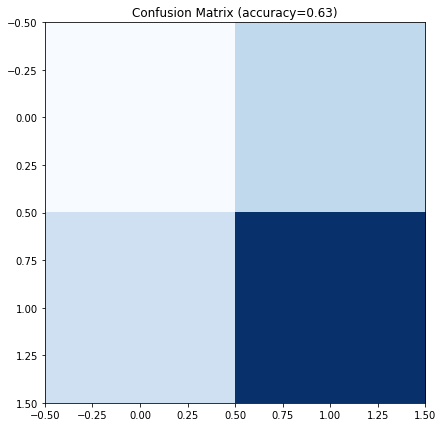

In [11]:
%matplotlib inline

fig = plt.figure(figsize=(7, 7))

y_test = []
y_pred = []
for i in range(0, 10):
    y_test.extend(exe['pipeline0']['folds'][str(i)]['Actual'])
    y_pred.extend(exe['pipeline0']['folds'][str(i)]['predicted'])

y_test = pd.Categorical(pd.Series(y_test)).codes
y_pred = pd.Categorical(pd.Series(y_pred)).codes

plt.title("Confusion Matrix (accuracy=%.2f)" % accuracy_score(y_test, y_pred))
plt.imshow(pd.crosstab(y_test, y_pred), cmap="Blues")

plt.show()

------------